In [1]:
# Add additional library
import sys, os
data_lib = os.path.abspath('../data')
eda_sp_lib = os.path.abspath('../signal_processing')
if data_lib not in sys.path:
    sys.path.append(data_lib)
if eda_sp_lib not in sys.path:
    sys.path.append(eda_sp_lib)

from data_utils import *
from visualisation_utils import *
from bvp_signal_processing import *
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
import pywt

In [2]:
BVP_SAMPLING_RATE = 64

dp_manager = get_data_path_manager()
wesad_wrist_metadata = load_metadata(dp_manager.WESAD_wrist_metadata_path)

In [3]:
DATASET_NAME = 'WESAD'
DEVICE = 'wrist'
SIGNAL_NAME = 'BVP'
USER_ID = 'S10'

In [4]:
raw_signal = load_raw_signal(dp_manager, DATASET_NAME, USER_ID, DEVICE, SIGNAL_NAME)
user_metadata = wesad_wrist_metadata[USER_ID]

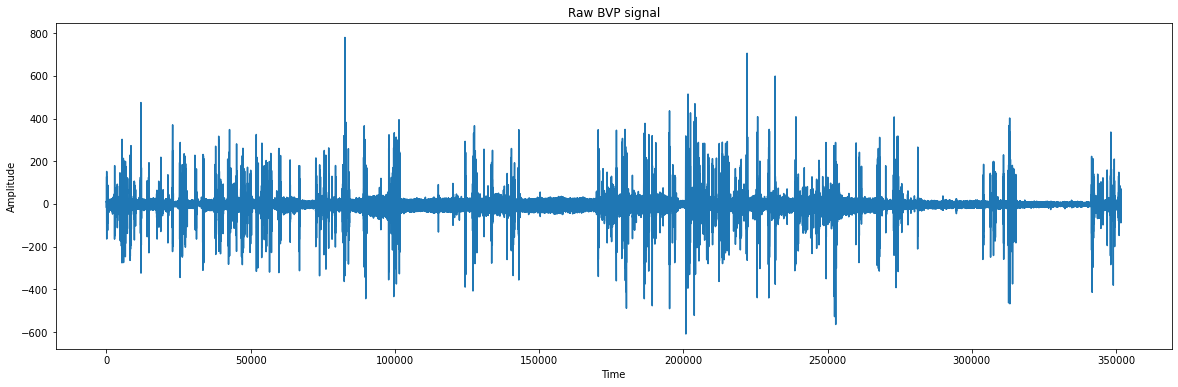

In [5]:
plot_signal(raw_signal, title = 'Raw BVP signal')

In [6]:
bvp_processor = BVP_Signal_Processor()

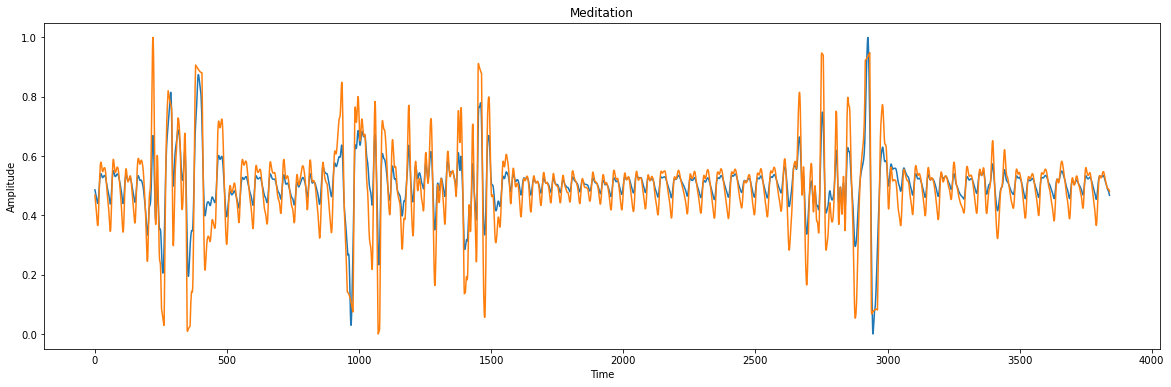

In [7]:
starting_index = user_metadata['bvp']['starting_indices'][2]
ending_index = user_metadata['bvp']['ending_indices'][2]
trim_indices = (starting_index, ending_index)
meditation_trimmed_signal = get_trimmed_signal(raw_signal, trim_indices, lag = 60, sampling_rate = BVP_SAMPLING_RATE)
m_signal = meditation_trimmed_signal[200:200 + BVP_SAMPLING_RATE * 60]
scaled_m_signal = bvp_processor.min_max_norm(m_signal)
cleaned_m_signal = bvp_processor.clean_bvp(m_signal, BVP_SAMPLING_RATE)
plot_two_signals([scaled_m_signal, cleaned_m_signal], title = 'Meditation')

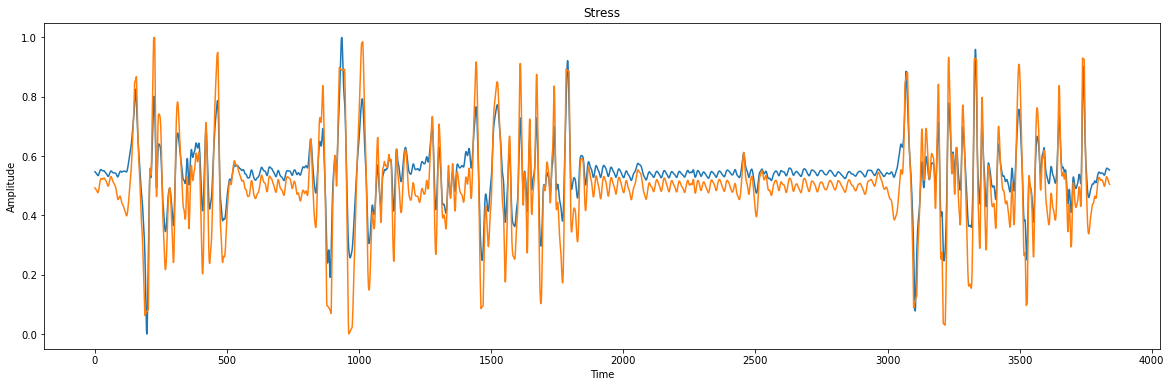

In [8]:
starting_index = user_metadata['bvp']['starting_indices'][3]
ending_index = user_metadata['bvp']['ending_indices'][3]
trim_indices = (starting_index, ending_index)
stress_trimmed_signal = get_trimmed_signal(raw_signal, trim_indices, lag = 60, sampling_rate = BVP_SAMPLING_RATE)
s_signal = stress_trimmed_signal[200:200 + BVP_SAMPLING_RATE * 60]
scaled_s_signal = bvp_processor.min_max_norm(s_signal)
cleaned_s_signal = bvp_processor.clean_bvp(s_signal, BVP_SAMPLING_RATE)
plot_two_signals([scaled_s_signal, cleaned_s_signal], title = 'Stress')

In [9]:
import neurokit2 as nk

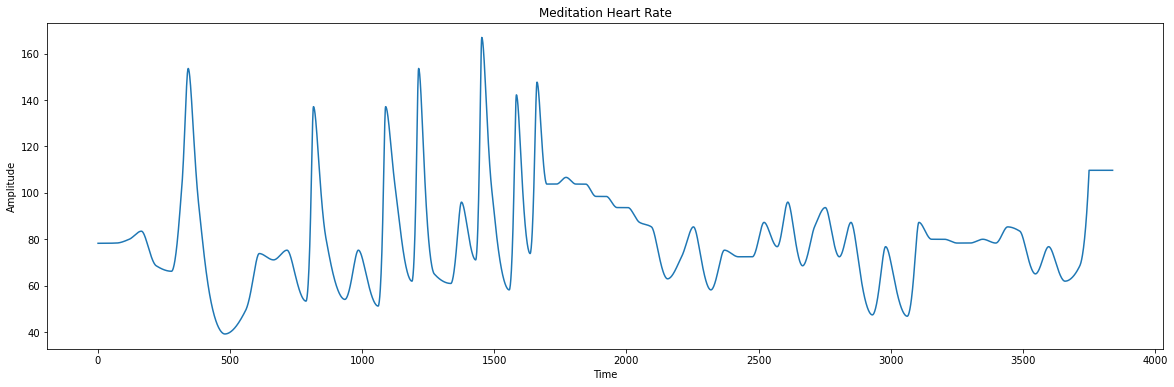

In [10]:
ppg_signal, info = nk.ppg_process(cleaned_m_signal, sampling_rate = BVP_SAMPLING_RATE)
plot_signal(ppg_signal['PPG_Rate'], title = 'Meditation Heart Rate')

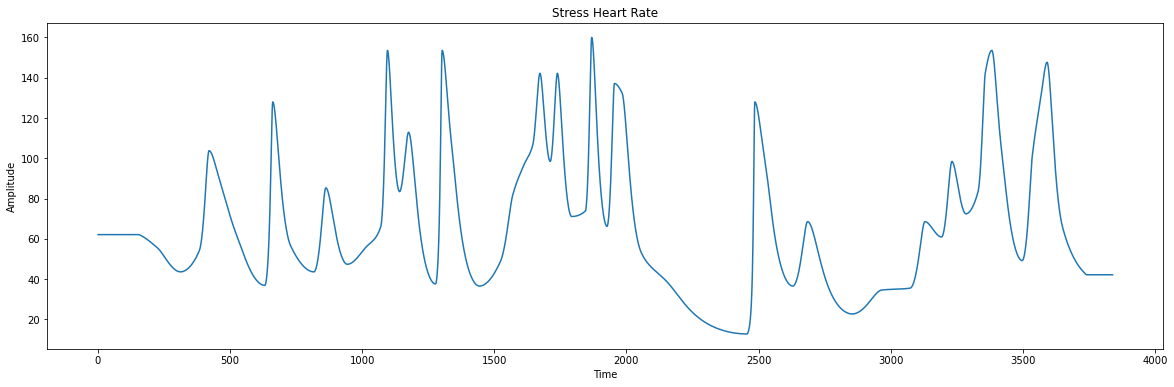

In [11]:
ppg_signal, info = nk.ppg_process(cleaned_s_signal, sampling_rate = BVP_SAMPLING_RATE)
plot_signal(ppg_signal['PPG_Rate'], title = 'Stress Heart Rate')

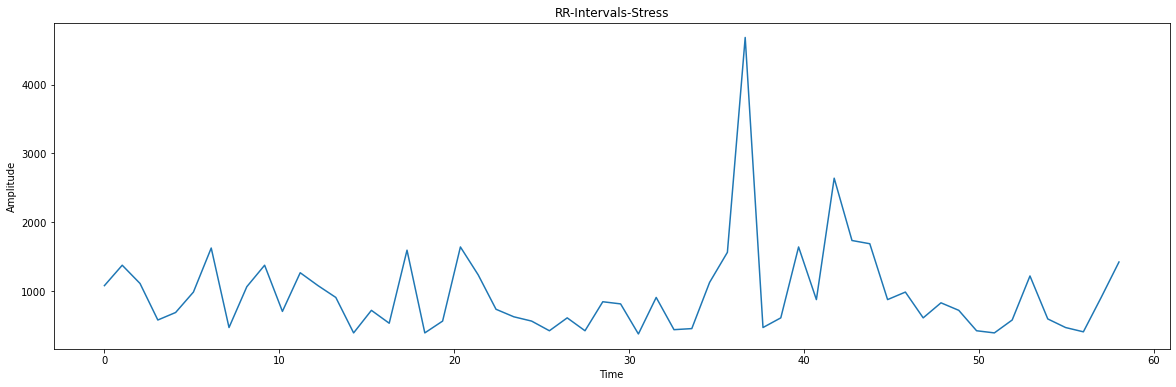

In [12]:
s_rr_intervals = bvp_processor.extract_rr_intervals(cleaned_s_signal, BVP_SAMPLING_RATE)
plot_signal(s_rr_intervals, title = 'RR-Intervals-Stress')

2 outlier(s) have been deleted.
The outlier(s) value(s) are : [4687.5, 2640.625]
26 ectopic beat(s) have been deleted with malik rule.


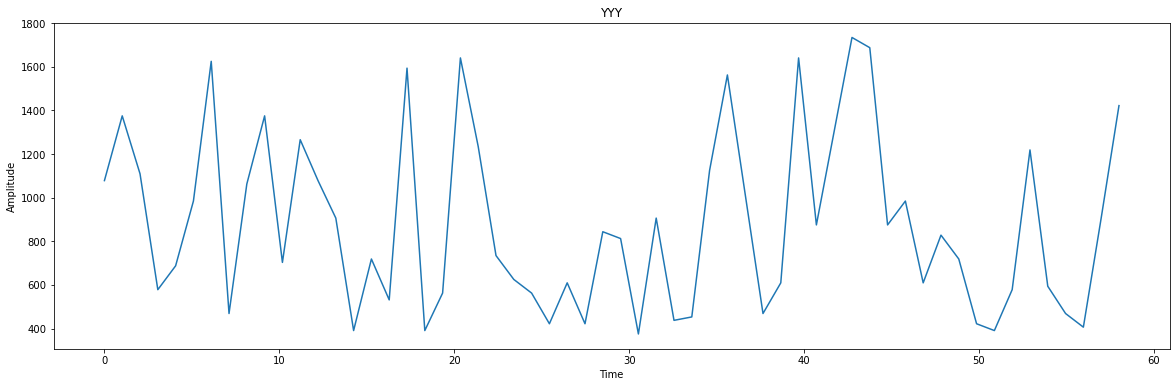

In [13]:
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values, get_frequency_domain_features, get_time_domain_features, get_geometrical_features, get_poincare_plot_features
# rr_intervals_list contains integer values of RR-interval
rr_intervals_list = s_rr_intervals

# This remove outliers from signal
rr_intervals_without_outliers = remove_outliers(rr_intervals=rr_intervals_list,  
                                                low_rri=300, high_rri=2000)
# This replace outliers nan values with linear interpolation
interpolated_rr_intervals = interpolate_nan_values(rr_intervals=rr_intervals_without_outliers, 
                                                   interpolation_method="linear")

# This remove ectopic beats from signal
nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method="malik")
# This replace ectopic beats nan values with linear interpolation
interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)
plot_signal(interpolated_rr_intervals, title = 'YYY')

In [14]:
get_frequency_domain_features(interpolated_nn_intervals, sampling_frequency = BVP_SAMPLING_RATE)

{'lf': 5899.565509397846,
 'hf': 19074.02983385559,
 'lf_hf_ratio': 0.3092983266140419,
 'lfnu': 23.623212550337094,
 'hfnu': 76.37678744966291,
 'total_power': 25745.046292956733,
 'vlf': 771.4509497032959}

In [15]:
get_frequency_domain_features(interpolated_nn_intervals, sampling_frequency = BVP_SAMPLING_RATE, method = 'lomb')

{'lf': 14965.717298544658,
 'hf': 31424.316228040676,
 'lf_hf_ratio': 0.4762463943508304,
 'lfnu': 32.26063048643425,
 'hfnu': 67.73936951356575,
 'total_power': 56982.67973719325,
 'vlf': 10592.646210607916}

In [16]:
get_time_domain_features(interpolated_nn_intervals)

{'mean_nni': 959.8599137931035,
 'sdnn': 336.77539285968163,
 'sdsd': 319.87767857734224,
 'nni_50': 50,
 'pnni_50': 87.71929824561404,
 'nni_20': 55,
 'pnni_20': 96.49122807017544,
 'rmssd': 319.9345223880659,
 'median_nni': 906.25,
 'range_nni': 1296.875,
 'cvsd': 0.3333137656762561,
 'cvnni': 0.35085889932504577,
 'mean_hr': 71.32884506546415,
 'max_hr': 153.6,
 'min_hr': 35.55555555555556,
 'std_hr': 27.83094435510232}

In [17]:
get_geometrical_features(interpolated_nn_intervals)

{'triangular_index': 19.333333333333332, 'tinn': None}

In [18]:
get_poincare_plot_features(interpolated_nn_intervals)

{'sd1': 228.19827232986765,
 'sd2': 418.04411128163184,
 'ratio_sd2_sd1': 1.8319337259369615}

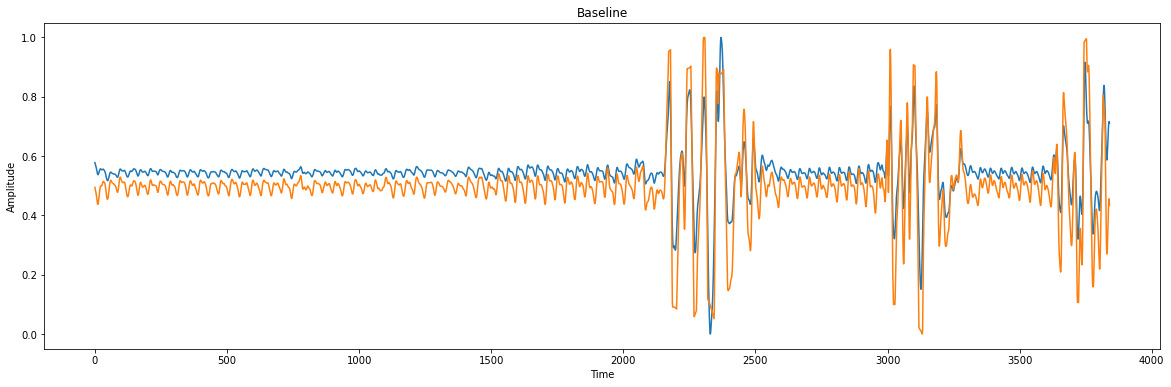

In [19]:
starting_index = user_metadata['bvp']['starting_indices'][0]
ending_index = user_metadata['bvp']['ending_indices'][0]
trim_indices = (starting_index, ending_index)
b_trimmed_signal = get_trimmed_signal(raw_signal, trim_indices, lag = 60, sampling_rate = BVP_SAMPLING_RATE)
b_signal = b_trimmed_signal[21096:24936]
scaled_b_signal = bvp_processor.min_max_norm(b_signal)
cleaned_b_signal = bvp_processor.clean_bvp(b_signal, BVP_SAMPLING_RATE)
plot_two_signals([scaled_b_signal, cleaned_b_signal], title = 'Baseline')

[1000.0, 1000.0, 1000.0, 1093.75, 1187.5, nan, 1828.125, 1875.0, nan, 765.625, nan, 578.125, 562.5, 593.75, 578.125, 593.75, 578.125, 578.125, 593.75, 593.75, 609.375, 578.125, 562.5, 578.125, 578.125, nan, 1609.375, nan, 812.5, 750.0, nan, 562.5, 515.625, 562.5, 562.5, 546.875, 562.5, 562.5, 578.125, 593.75, 593.75, 578.125, 578.125, 562.5, 578.125, nan, 609.375, nan, 406.25, nan, 546.875, nan, 546.875, nan, 593.75, 625.0, 625.0, 609.375, 625.0, 625.0, 625.0, 593.75, 656.25, 578.125, nan]
12 ectopic beat(s) have been deleted with malik rule.
[1000.0, 1000.0, 1000.0, 1093.75, 1187.5, nan, 1828.125, 1875.0, nan, 765.625, nan, 578.125, 562.5, 593.75, 578.125, 593.75, 578.125, 578.125, 593.75, 593.75, 609.375, 578.125, 562.5, 578.125, 578.125, nan, 1609.375, nan, 812.5, 750.0, nan, 562.5, 515.625, 562.5, 562.5, 546.875, 562.5, 562.5, 578.125, 593.75, 593.75, 578.125, 578.125, 562.5, 578.125, nan, 609.375, nan, 406.25, nan, 546.875, nan, 546.875, nan, 593.75, 625.0, 625.0, 609.375, 625.0, 

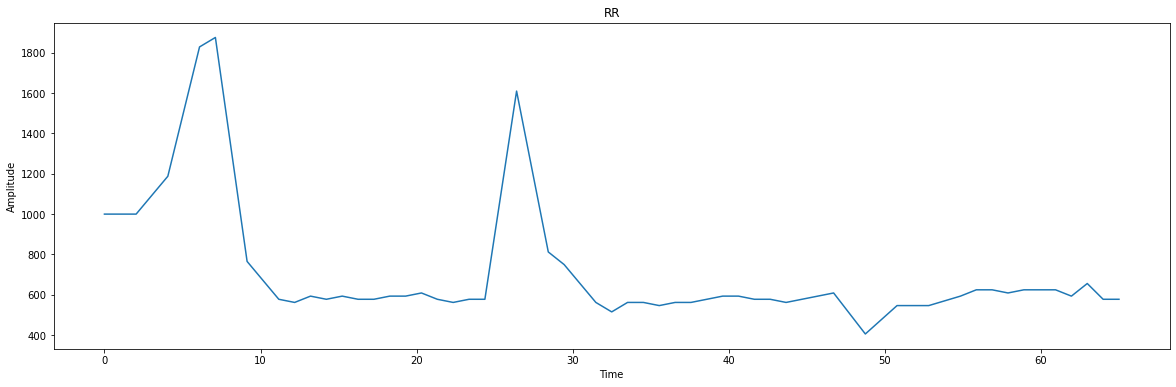

In [20]:
rri = bvp_processor.extract_rr_intervals(cleaned_b_signal, BVP_SAMPLING_RATE)
interpolated_rr_intervals, interpolated_nn_intervals = bvp_processor.clean_rr_intervals(rri)
nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method="malik")

rr_intervals = nn_intervals_list
if np.isnan(rr_intervals[0]):
    start_idx = 0

    while np.isnan(rr_intervals[start_idx]):
        start_idx += 1

    rr_intervals[0:start_idx] = [rr_intervals[start_idx]] * start_idx
else:
    pass
print(rr_intervals)
print(interpolated_nn_intervals)
plot_signal(interpolated_nn_intervals, 'RR')

In [21]:
nni_tmstp = np.cumsum(interpolated_nn_intervals)
# nni_tmstp = nni_tmstp - nni_tmstp[0]
nni_tmstp

array([ 1000.    ,  2000.    ,  3000.    ,  4093.75  ,  5281.25  ,
        6789.0625,  8617.1875, 10492.1875, 11812.5   , 12578.125 ,
       13250.    , 13828.125 , 14390.625 , 14984.375 , 15562.5   ,
       16156.25  , 16734.375 , 17312.5   , 17906.25  , 18500.    ,
       19109.375 , 19687.5   , 20250.    , 20828.125 , 21406.25  ,
       22500.    , 24109.375 , 25320.3125, 26132.8125, 26882.8125,
       27539.0625, 28101.5625, 28617.1875, 29179.6875, 29742.1875,
       30289.0625, 30851.5625, 31414.0625, 31992.1875, 32585.9375,
       33179.6875, 33757.8125, 34335.9375, 34898.4375, 35476.5625,
       36070.3125, 36679.6875, 37187.5   , 37593.75  , 38070.3125,
       38617.1875, 39164.0625, 39710.9375, 40281.25  , 40875.    ,
       41500.    , 42125.    , 42734.375 , 43359.375 , 43984.375 ,
       44609.375 , 45203.125 , 45859.375 , 46437.5   , 47015.625 ])

In [22]:
bvp_processor.extract_statistical_feature(cleaned_b_signal, BVP_SAMPLING_RATE)

[1000.0, 1000.0, 1000.0, 1093.75, 1187.5, nan, 1828.125, 1875.0, nan, 765.625, nan, 578.125, 562.5, 593.75, 578.125, 593.75, 578.125, 578.125, 593.75, 593.75, 609.375, 578.125, 562.5, 578.125, 578.125, nan, 1609.375, nan, 812.5, 750.0, nan, 562.5, 515.625, 562.5, 562.5, 546.875, 562.5, 562.5, 578.125, 593.75, 593.75, 578.125, 578.125, 562.5, 578.125, nan, 609.375, nan, 406.25, nan, 546.875, nan, 546.875, nan, 593.75, 625.0, 625.0, 609.375, 625.0, 625.0, 625.0, 593.75, 656.25, 578.125, nan]


array([ 9.26316220e+01,  2.36679512e+01,  7.23317308e+02,  3.16267247e+02,
        3.26653819e+00,  1.92711259e+00,  8.10683528e+02,  2.10000000e+01,
        3.28125000e+01,  3.00000000e+01,  4.68750000e+01,  5.00000000e+00,
        9.70018399e+03,  1.66920786e+02,  1.79717651e+02,  1.97856584e+03,
        7.54190050e+03,  2.62343138e-01,  2.07822366e+01,  7.92177634e+01,
        1.18871086e+02,  4.31183961e+02,  1.66790578e+02,  9.99219943e-01,
       -2.11374328e-03,  0.00000000e+00,  3.61733684e-01,  6.15084817e-01,
        2.58327966e+00,  7.62770756e-01])